### Data and imports

In [34]:
import numpy as np
import yfinance as yf # to get our data

from sklearn.preprocessing import MinMaxScaler # to normalize our classes
from sklearn.model_selection import train_test_split # from tutorial code
from sklearn.metrics import accuracy_score, confusion_matrix # needed for plotting

import matplotlib.pyplot as plt

import pandas as pd

import statsmodels

import warnings
warnings.filterwarnings("ignore")

#### Get Data from Yahoo Finance
We are using S&P 500 index as our training and testing data

In [35]:
dfs = {} # Store all the data for our tickers, even though for now its just SP500
tickers = ['^GSPC',] # Ticker (identifier) for the SP500, which is arguably the most influential, we start with just this

# Got this code from https://www.kaggle.com/code/xxxxyyyy80008/predict-stock-market-crashes 
for ticker in tickers:
    cur_data = yf.Ticker(ticker)
    hist = cur_data.history(period="max")
    print(ticker, cur_data.info['shortName'], ticker, hist.shape, hist.index.min(), hist.index.max())
    dfs[ticker] = hist

df = dfs['^GSPC']
df.describe()

^GSPC S&P 500 ^GSPC (24348, 7) 1927-12-30 00:00:00-05:00 2024-12-03 00:00:00-05:00


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,24348.000000,24348.000000,24348.000000,24348.000000,2.434800e+04,24348.0,24348.0
mean,634.340666,657.877501,650.053829,654.217687,9.167761e+08,0.0,0.0
std,1086.200533,1081.111016,1069.153587,1075.527702,1.625480e+09,0.0,0.0
min,0.000000,4.400000,4.400000,4.400000,0.000000e+00,0.0,0.0
25%,9.727500,24.730000,24.730000,24.730000,1.540000e+06,0.0,0.0
50%,43.355000,103.334999,101.709999,102.485001,2.067000e+07,0.0,0.0
75%,1046.812531,1052.842529,1037.722504,1046.767517,1.023875e+09,0.0,0.0
max,6042.970215,6053.580078,6035.330078,6049.879883,1.145623e+10,0.0,0.0


Let us see the data in the graph

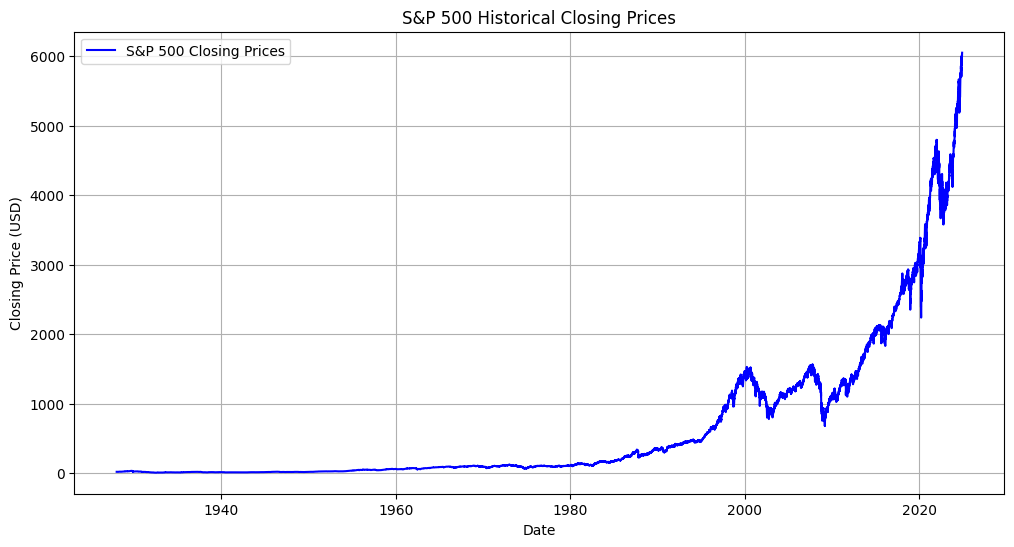

In [36]:
# Extract S&P 500 data
sp500_data = dfs['^GSPC']

# Use closing prices to plot the data
closing_prices = sp500_data['Close'].dropna()

# Convert index and values to np array
x = closing_prices.index.to_numpy()
y = closing_prices.to_numpy()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='S&P 500 Closing Prices', color='blue')
plt.title("S&P 500 Historical Closing Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Data Preprocessing
In this project, we define a market crash as a drawdown of the 99.5% quantile

In [37]:
# Calculates how much the price has gone down from its highest point, labeling those with a 0.005 quantile as crashes as per directive 1
# NOTE: got help from chatgpt for this function to find .pct_change, .cummax and .quantile
def calculate_drawdown_and_label(data, quantile_threshold=0.005):

    data['daily_return'] = data['Close'].pct_change()

    data['drawdown'] = data['Close'] / data['Close'].cummax() - 1

    crash_threshold = data['drawdown'].quantile(quantile_threshold)

    data['crash_label'] = (data['drawdown'] < crash_threshold).astype(int)

    return data

## Make the data we targeted the target (nice), we try to predict the market crashes 3 days in advance so shift_days = 3
def prepare_target(data, shift_days=3):
    data['target'] = (data['crash_label']).astype(int).shift(-shift_days) # complicated line that basically takes our data with crash label, turns the bools into an int, then shift the values by 3 days to predict in advance, since we want to predict 3 days in advance
    return data

# prepare the data
for ticker, data in dfs.items():
    data = calculate_drawdown_and_label(data) # get the drawdown for our data
    data = prepare_target(data)
    dfs[ticker] = data

df = dfs['^GSPC']
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,daily_return,drawdown,crash_label,target
count,24348.000000,24348.000000,24348.000000,24348.000000,2.434800e+04,24348.0,24348.0,24347.000000,24348.000000,24348.000000,24345.000000
mean,634.340666,657.877501,650.053829,654.217687,9.167761e+08,0.0,0.0,0.000311,-0.209155,0.005011,0.005011
std,1086.200533,1081.111016,1069.153587,1075.527702,1.625480e+09,0.0,0.0,0.011934,0.227219,0.070610,0.070614
min,0.000000,4.400000,4.400000,4.400000,0.000000e+00,0.0,0.0,-0.204669,-0.861896,0.000000,0.000000
25%,9.727500,24.730000,24.730000,24.730000,1.540000e+06,0.0,0.0,-0.004545,-0.316712,0.000000,0.000000
50%,43.355000,103.334999,101.709999,102.485001,2.067000e+07,0.0,0.0,0.000492,-0.120194,0.000000,0.000000
75%,1046.812531,1052.842529,1037.722504,1046.767517,1.023875e+09,0.0,0.0,0.005465,-0.025560,0.000000,0.000000
max,6042.970215,6053.580078,6035.330078,6049.879883,1.145623e+10,0.0,0.0,0.166096,0.000000,1.000000,1.000000


### Pre-process data

Let us see where are the crashes

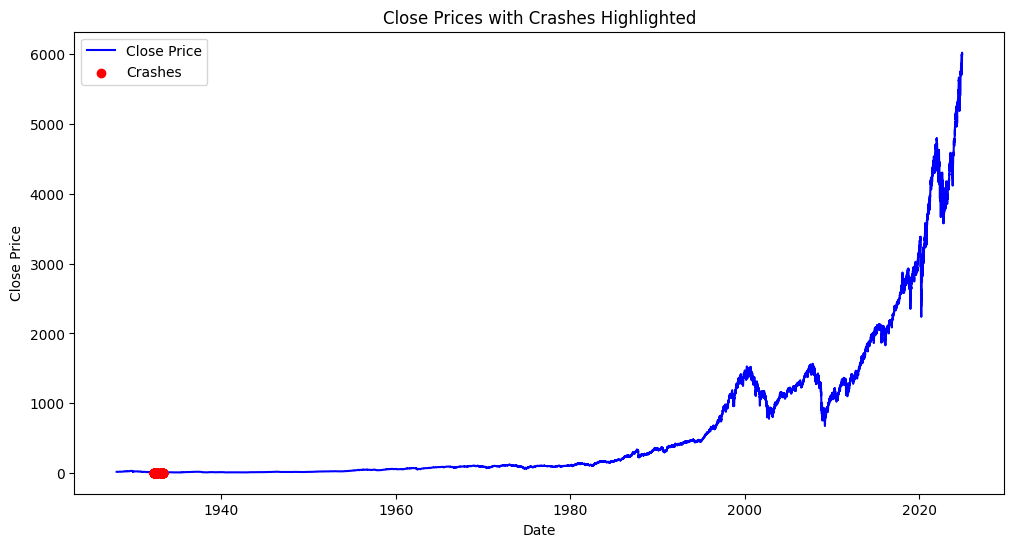

In [38]:
from sklearn.model_selection import train_test_split

# Define the feature columns (X) and target column (y)
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'daily_return', 'drawdown', 'crash_label']
target_column = 'target'

# Drop rows with NaN values in the target column (due to shifting)
df = df.dropna(subset=[target_column])

# Separate features and target
X = df[feature_columns]
y = df[target_column]

crash_indices = df[df['crash_label'] == 1].index

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')

plt.scatter(crash_indices, df.loc[crash_indices, 'Close'], color='red', label='Crashes', zorder=5)

plt.title("Close Prices with Crashes Highlighted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

The crashes are concentrated in the 1920-1930s, which is because of the Wall street crash of 1929, we will only use the data between this period and split the training set and test set.

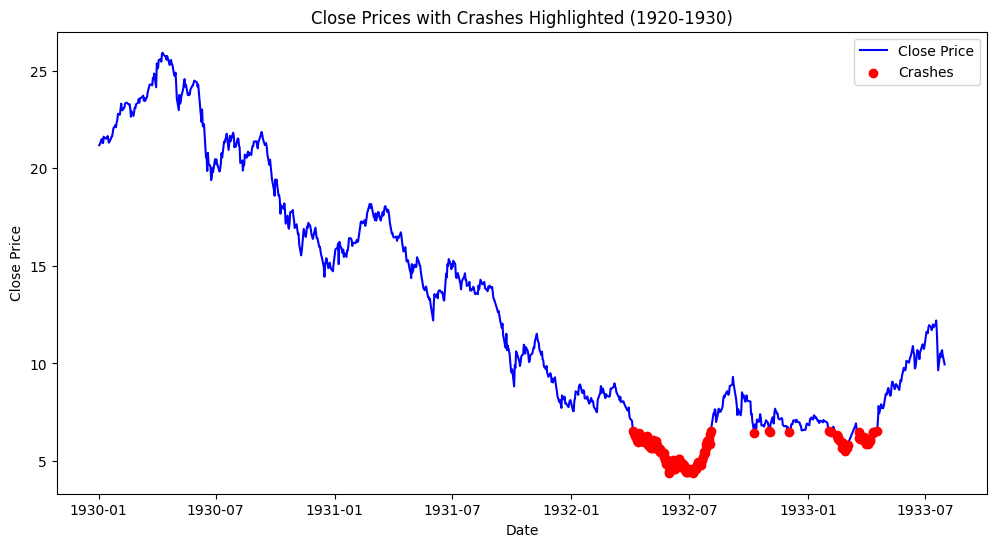

In [39]:
df.index = pd.to_datetime(df.index)

# Filter the data between 1920 and 1930
df_1920s = df[(df.index >= '1930-01-01') & (df.index <= '1933-07-31')]

crash_indices_1920s = df_1920s[df_1920s['crash_label'] == 1].index

# Plot the Close prices in the 1920-1930 period
plt.figure(figsize=(12, 6))
plt.plot(df_1920s.index, df_1920s['Close'], label='Close Price', color='blue')

# Highlight crash points
plt.scatter(crash_indices_1920s, df_1920s.loc[crash_indices_1920s, 'Close'], color='red', label='Crashes', zorder=5)

# Add labels and legend
plt.title("Close Prices with Crashes Highlighted (1920-1930)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [40]:
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'daily_return', 'drawdown']
target_column = 'target'

# Drop rows with NaN values in the target column (due to shifting)
df = df_1920s.dropna(subset=[target_column])

# Separate features and target
X = df[feature_columns]
y = df[target_column]

# Chronological train-test split (e.g., 80% train, 20% test)
train_size = int(0.8 * len(df))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 712
Test set size: 179


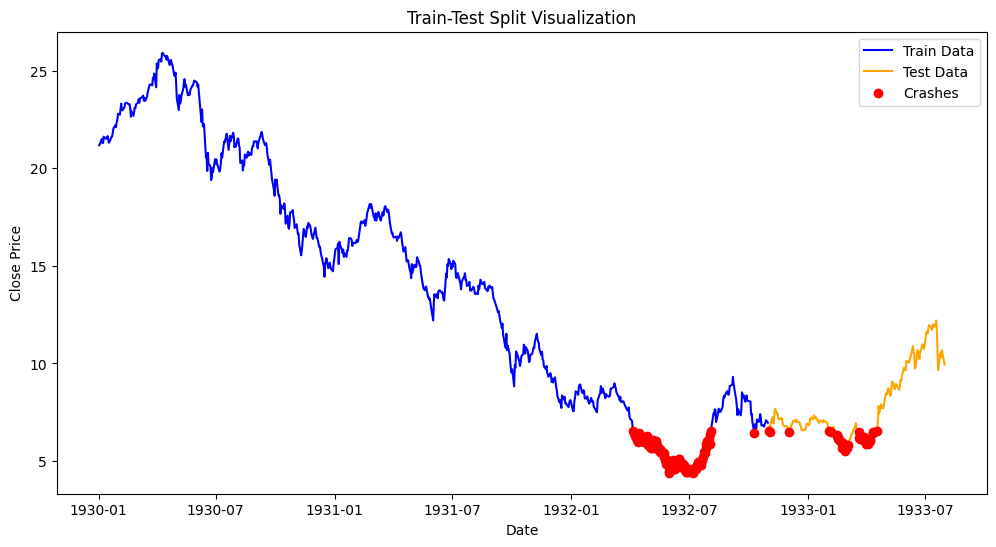

Number of total crashes: 122.0
Number of crashes in train: 88.0
Number of crashes in test: 34.0


In [41]:
# Plot Close prices with train and test data in different colors
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(df.index[:train_size], df['Close'][:train_size], label='Train Data', color='blue')

# Plot test data
plt.plot(df.index[train_size:], df['Close'][train_size:], label='Test Data', color='orange')

plt.scatter(crash_indices_1920s, df_1920s.loc[crash_indices_1920s, 'Close'], color='red', label='Crashes', zorder=5)

# Add labels and legend
plt.title("Train-Test Split Visualization")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()
print(f'Number of total crashes: {y.sum()}')
print(f'Number of crashes in train: {y_train.sum()}')
print(f'Number of crashes in test: {y_test.sum()}')

### Testing for stationarity: Augmented Dickey-Fuller Test

In [42]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df_1920s['Close'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('ADF p-value: %f' % adf_test[1])

from statsmodels.tsa.stattools import kpss
kpss_result = kpss(df_1920s['Close'])
print(f'KPSS result: {kpss_result[1]}')

ADF Statistic: -1.300958
ADF p-value: 0.628734
KPSS result: 0.01


The ADF test and KPSS test both suggest that our data is non-stationary, therefore the difference term is needed.

### Decision for p (lag of autoregressive term) and q (order of moving average term)

For p, we need to plot PACF and for q we need to plot ACF

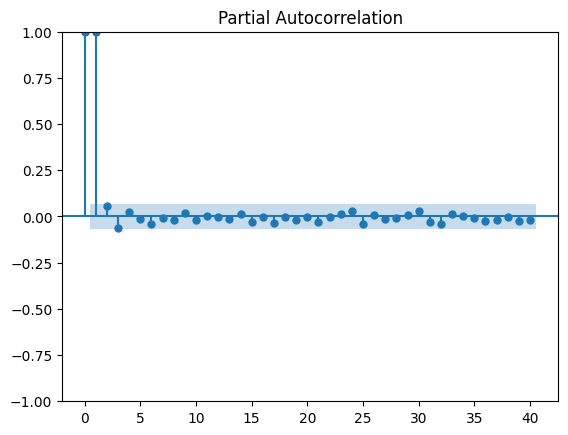

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(df_1920s['Close'], lags=40)
plt.show()

The PACF suggested $p=1$ or $2$ for the autoregression term

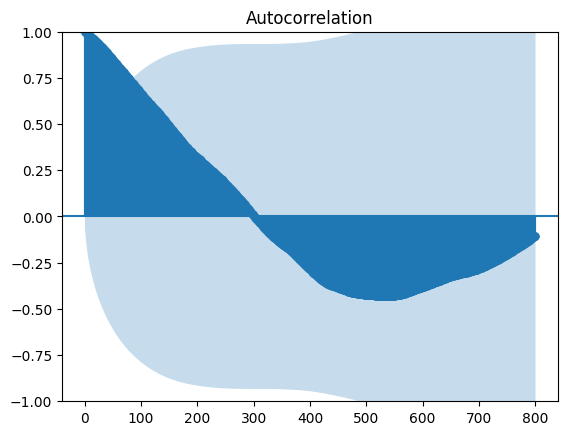

In [44]:
plot_acf(df_1920s['Close'], lags=800)
plt.show()

In [45]:
from statsmodels.tsa.arima.model import ARIMA

arima_order = (2, 0, 2)  # Testing some different sets
model = ARIMA(X_train['Close'], order=arima_order)
fitted_model = model.fit()

# Print summary of the model
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  712
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -176.596
Date:                Wed, 04 Dec 2024   AIC                            365.191
Time:                        11:00:28   BIC                            392.600
Sample:                             0   HQIC                           375.778
                                - 712                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.2656      5.518      2.585      0.010       3.451      25.080
ar.L1          0.6229      0.176      3.529      0.000       0.277       0.969
ar.L2          0.3756      0.176      2.135      0.0

In [46]:
forecast_steps = len(X_test)
forecast = fitted_model.forecast(steps=forecast_steps)

# Convert forecast to a DataFrame for comparison
forecast_df = X_test.copy()

# Assign forecast values to the DataFrame
forecast_df['Forecast'] = forecast.values if hasattr(forecast, 'values') else forecast

# Verify if the assignment is correct
print(forecast_df[['Close', 'Forecast']].head())

                           Close  Forecast
Date                                      
1932-11-01 00:00:00-05:00   6.76  6.996904
1932-11-02 00:00:00-05:00   6.52  6.981702
1932-11-03 00:00:00-05:00   6.48  6.998356
1932-11-04 00:00:00-05:00   6.88  7.003019
1932-11-07 00:00:00-05:00   7.24  7.012179


In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

mse = mean_squared_error(X_test['Close'], forecast)
mape = mean_absolute_percentage_error(X_test['Close'], forecast)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")

Mean Squared Error: 2.488111197093061
Mean Absolute Percentage Error: 14.42%


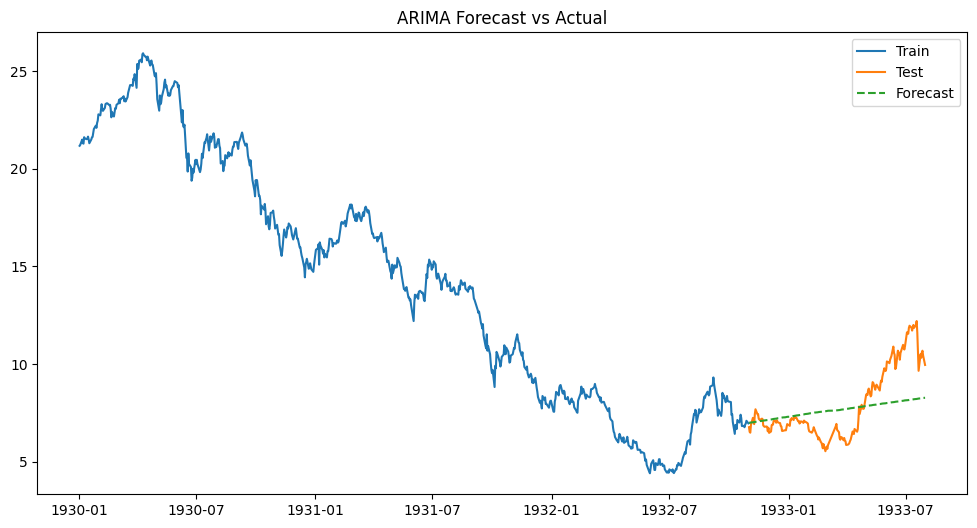

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(X_train['Close'], label='Train')
plt.plot(X_test['Close'], label='Test')
plt.plot(forecast_df['Forecast'], label='Forecast', linestyle='--')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

This looks so bad

In [49]:
forecast_df['forecast_drawdown'] = forecast_df['Forecast'] / forecast_df['Forecast'].cummax() - 1

# Use the same crash threshold as the training phase
crash_threshold = X_train['drawdown'].quantile(0.005)

# Predicted crashes (forecasted drawdowns below threshold)
forecast_df['predicted_crash'] = (forecast_df['forecast_drawdown'] < crash_threshold).astype(int)

# Count the number of predicted crashes
num_predicted_crashes = forecast_df['predicted_crash'].sum()

print(f"Number of crashes predicted in the test set: {num_predicted_crashes}")

Number of crashes predicted in the test set: 0
